## Homework part B: implementing a sample size estimator for interleaving experiments

#### by Kim de Bie, Bram van den Heuvel and Kiki van Rongen

In [3]:
import pandas as pd
import csv
import random
from collections import defaultdict, Counter
import copy
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import texttable as tt

### Step 1: Simulate Rankings of Relevance for E and P

In the first step we generate pairs of rankings, for the production P and experimental E, respectively. We assume a binary relevance. Documents can be distinct but they may also overlap. Further, we assume that the algorithms are used on mobiles, so we are interested only in rankings of length 3. In addition, we calculate the ERR score and delta-ERR for rankings and pairs.

In [4]:
class Ranking:
    '''The ranking class contains the ranking of one particular algorithm (E or P). Rankings
    contain id, ERR score and methods to combine them, and the ranking list plus relevance labels.'''

    def __init__(self, id, ranker):
        self.id = id
        self.ERR = 0
        self.ranker = ranker
        self.ranking = [{'id': 1, 'relevance': 0}, {'id': 2, 'relevance': 0}, {'id': 3, 'relevance': 0}]

    def set_ERR(self):
        self.ERR = self.calculate_ERR()
        
    def calculate_ERR(self):

        max_rl = 1

        thetas = []
        for idx, docu in enumerate(self.ranking):
            rl = docu['relevance']
            thetas.append((2**rl - 1) / (2**max_rl))
            

        # calculate ERR as sum of products
        ERR = 0
        for rank, doc in enumerate(self.ranking):
            prod = 1
            for i in range(rank):
                prod *= (1-thetas[i])
            ERR+= (prod * thetas[rank])/ (rank+1)
            
        return ERR
    

class Pair:
    '''A pair contains two Rankings and their delta-ERR.'''
    
    def __init__(self, ranking_E, ranking_P):
        self.rankings = [ranking_E, ranking_P]
        self.delta_ERR = ranking_E.ERR - ranking_P.ERR


def create_pairs():

    """
    This function creates two ranked lists of documents for algorithm P and E.
    Subsequently, it forms E-P pairs of possible rankings.
    """

    # CREATE RANKED LIST FOR E

    rankings_E = []
    rankings_P = []

    # define all possible combinations of relevance labels
    rl_permutations = [[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]]

    # assign id to the rankings
    id = 0

    # iterate over permutations of relevance labels
    for rl_perm in rl_permutations:

        # create ranking object and adjust its relevance labels
        rank_E = Ranking(id, 'E')
        for i, document_E in enumerate(rank_E.ranking):
             document_E['relevance'] = rl_perm[i]

        # calculate ERR
        rank_E.set_ERR()

        # store ranking list for E
        rankings_E.append(rank_E)
        id += 1

    # CREATE RANKED LIST FOR P

    # define all possible id's for P
    id_permutations = [[1, 5, 6], [2, 5, 6], [3, 5, 6], [4, 5, 6], \
                       [4, 1, 6], [4, 2, 6], [4, 3, 6], \
                       [4, 5, 1], [4, 5, 2], [4, 5, 3], \
                       [1, 2, 6], [1, 5, 2], [4, 1, 2], \
                       [1, 3, 6], [1, 5, 3], [4, 1, 3], \
                       [2, 3, 6], [2, 5, 3], [4, 2, 3], \
                       [2, 1, 6], [2, 5, 1], [4, 2, 1], \
                       [3, 1, 6], [3, 5, 1], [4, 3, 1], \
                       [3, 2, 6], [3, 5, 2], [4, 3, 2], \
                       [1, 2, 3], [1, 3, 2], [3, 1, 2], [3, 2, 1], [2, 1, 3], [2, 3, 1]]

    # iterate over possible id's for P
    for id_perm in id_permutations:

        # iterate over permutations of relevance labels
        for rl_perm in rl_permutations:

            # create ranking object for P
            rank_P = Ranking(id, 'P')

            # adjust relevance labels & id numbers
            for j, document_P in enumerate(rank_P.ranking):
                document_P['relevance'] = rl_perm[j]
                document_P['id'] = id_perm[j]

            # calculate ERR
            rank_P.set_ERR()

            # store ranking list for P
            rankings_P.append(rank_P)
            id += 1

    # FORM E-P PAIRS

    pairs = []

    for rank_E in rankings_E:

        # store ids and relevance labels of E
        ids_E = [1, 2, 3]
        rl_E = [d.get('relevance') for d in rank_E.ranking]

        for rank_P in rankings_P:

            # keep track of errors (duplicates with non-matching rl's)
            error = False

            # store ids and relevance labels of P
            ids_P = [d.get('id') for d in rank_P.ranking]
            rl_P = [d.get('relevance') for d in rank_P.ranking]

            # iterate over ids of P
            for idx, id in enumerate(ids_P):

                # check for duplicates with non-matching relevance labels
                if (id in ids_E) & (rl_P[idx] != rl_E[idx]):
                    error = True
                    break

            # create pair and add to list, if no error occurs
            if not error:
                pair = Pair(rank_E, rank_P)
                if 0.05 < pair.delta_ERR < 0.95:
                    pairs.append(pair)

    return pairs

pairs = create_pairs()
counter = Counter()
for i, p in enumerate(pairs):
    counter[p.delta_ERR] += 1
        
print(counter)

Counter({0.16666666666666666: 26, 0.5: 17, 0.25: 17, 0.3333333333333333: 17, 0.125: 13, 0.375: 13, 0.08333333333333337: 13, 0.41666666666666674: 13, 0.08333333333333331: 13, 0.08333333333333326: 13, 0.33333333333333337: 5, 0.08333333333333334: 4, 0.625: 4, 0.2916666666666667: 4, 0.5833333333333334: 4, 0.25000000000000006: 4, 0.16666666666666663: 4, 0.41666666666666663: 4, 0.16666666666666669: 1, 0.45833333333333337: 1, 0.6666666666666666: 1})


### Step 2: Implement Team-Draft Interleaving and Probabilistic Interleaving

We implement Team-Draft and Probabilistic Interleaving, with methods that interleave two rankings, and given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.


In [6]:
class Interleaved:
    def __init__(self, pair):
        """
        A class containing a pair of rankings, has methods to interleave
        these rankings into a list as well as counters to keep track of how
        often pair.rankings[0] (or E) wins.
        input:
            pair: A Pair object as defined earlier in the notebook
        """
        self.pair = pair
        self.list = None
        self.wins_team_draft_pbm = 0
        self.wins_probabilistic_pbm = 0
        self.wins_team_draft_rcm = 0
        self.wins_probabilistic_rcm = 0

    def team_draft(self):
        """
        Modifies self.list in place.
        Takes the rankings in self.pair and merges them using team draft
        interleaving. The interleaved list contains tuples of form
        (relevance, ranker).
        """
        interleaved_list = []
        available_E = set([i["id"] for i in self.pair.rankings[0].ranking])
        available_P = set([i["id"] for i in self.pair.rankings[1].ranking])
        available = available_E.union(available_P)
        team = [0,0]

        while len(available_E.intersection(available)) > 0 \
                and len(available_P.intersection(available)) > 0:

            # Flip a coin to determine which ranker is first
            ranker = int(team[0] > team[1] or (team[0] == team[1]
                         and random.choice([0,1]) == 1))

            for document in self.pair.rankings[ranker].ranking:
                if document["id"] in available:
                    interleaved_list.append((document["relevance"], ranker))
                    available.remove(document["id"])
                    team[ranker] += 1
                    break


        self.list = interleaved_list[:3]

    def probabilistic(self):
        """
        Modifies self.list in place.
        Takes the rankings in self.pair and merges them using probabilistic
        interleaving. The interleaved list contains tuples of form
        (relevance, ranker).
        """
        l1 = copy.copy(self.pair.rankings[0].ranking)
        l2 = copy.copy(self.pair.rankings[1].ranking)
        lists = [l1, l2]
        interleaved_list = []

        # As long as something is still true:
        while len(l1) > 0 and len(l2) > 0:

            # Randomly select one of the lists
            ranker = random.choice([0,1])
            random_l = lists[ranker]

            # Sample d from lx using a softmax
            document_rank = self.sample_softmax(len(random_l))
            document = random_l[document_rank]

            # Put d in l and remove from l1 and l2
            interleaved_list.append((document["relevance"], ranker))
            for l in lists:
                try:
                    l.remove(document)
                except ValueError:
                    pass

        self.list = interleaved_list[:3]

    def sample_softmax(self, length):
        """
        Returns an integer from 0 to length according to a softmax
        function.
        """
        normalization = sum([1/i**3 for i in range(1, length + 1)])

        sample = random.random()
        total = 0

        for i in range(1, length + 1):
            total += (1/i**3)/normalization
            if sample < total:
                return i - 1

        # You should never get here error
        raise notImplementedError()

### Step 3:  Simulate user clicks
Having interleaved all the ranking pairs in each group (for each measure) an online experiment could be ran. However, given that we do not have any real users (and the entire homework is a big simulation) we will simulate user clicks.

We consider the Position Based Model (PBM) for clicks. The parameters of PBM are estimated based on the Expectation-Maximization (EM) method. We first learn the parameters of the model given the Yandex Click Log. We predict the click probability given a ranked list of relevance labels. Then, we decide - stochastically - whether a document is clicked based on these probabilities.

After training PBM, we use the learnt parameters γr , while instead of the 𝑎uq learnt we use epsilon for the non-relevant documents (for a small value of epsilon) and 1-epsilon for the relevant documents.

We further consider and implement a Random Click Model, which will be used for a sanity check.


In [5]:
filename = "../data/YandexRelPredChallenge.txt"

def load_data(data):
    '''This function loads data into an appropriate form for further analysis.
    Input: Yandex Click Log file
    Output: a pandas dataframe with rows of format [QueryID, [ResultIDs], [Clicked]]'''

    completed_queries = []
    rank = 3

    with open(data) as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:

            if row[2] == 'Q':
                try:
                    completed_queries.append(query)
                except:
                    pass
                query = row
                query.append([])
                query.append([])

                for i in range(5, rank+5):
                    query[15].append(query[i])
                    query[16].append(False)

            else:
                for i in range(0, rank):
                    if row[3] == query[15][i]:
                        query[16][i] = True

    headers = ['SessionID', 'TimePassed', 'TypeOfAction', 'QueryID', 'RegionID', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'ResultIDs', 'Clicked']
    qd_pairs = pd.DataFrame(completed_queries, columns=headers)
    qd_pairs = qd_pairs[['QueryID', 'ResultIDs', 'Clicked']]

    return qd_pairs

def learn_model_parameters(qd_pairs):

    '''This method takes as input the Yandex click log. It trains the alpha and
     gamma parameters for the PBM model on the basis of this file. It saves the
    alphas and gammas (so they only have to be trained once) to a csv and
    returns them.'''

    iterations = 50

    ## EM algorithm for finding optimal alpha and gamma ##

    # Set parameters to initial values
    max_rank = 3
    alphas = defaultdict(lambda: 0.5)
    gammas = [0.5] * max_rank

    for ctr in range(0, iterations):
        print("Round " + str(ctr))

        print("Update alphas")

        # update one alpha for each QD pair
        new_alphas = defaultdict(lambda:1)
        qd_count = defaultdict(lambda:2)

        for i, session in qd_pairs.iterrows():

            if i%10000 == 0:
                print(str(i) + " sessions visited")

            for rank in range(max_rank):
                query = session["QueryID"]
                result = session["ResultIDs"][rank]
                click_u = float(session["Clicked"][rank])

                old_alpha = max(alphas[(query, result)], 0.000001)
                old_gamma = max(gammas[rank], 0.000001)

                qd_count[(query, result)] += 1

                # add new weights to dictionary
                new_alphas[(query, result)] += click_u + (1-click_u) * \
                ((1-old_gamma)*old_alpha / (1-old_gamma*old_alpha))

        for key, value in qd_count.items():
            new_alphas[key] /= value

        alphas = new_alphas


        print("Update gammas")

        new_gammas = [0] * max_rank

        # update one gamma per rank
        for i, session in qd_pairs.iterrows():

            if i%10000 == 0:
                print(str(i) + " sessions visited")

            for rank in range(max_rank):
                query = session["QueryID"]
                result = session["ResultIDs"][rank]
                click_u = float(session["Clicked"][rank])
                old_gamma = gammas[rank]
                old_alpha = alphas[(query, result)]

                new_gammas[rank] += click_u + (1-click_u) * \
                    (old_gamma*(1-old_alpha)) / (1-old_gamma*old_alpha)

        for rank, value in enumerate(gammas):
            gammas[rank] = new_gammas[rank] / qd_pairs.shape[0]

        print(gammas)

    alphas_df = pd.DataFrame.from_dict(alphas, orient='index')
    alphas_df.to_csv('trained_alphas.csv')

    gammas_df = pd.DataFrame({'gammas': gammas})
    gammas_df.to_csv('trained_gammas.csv')

    return alphas, gammas

def get_gammas_from_file():
    '''Use this method to load gammas when parameters are already trained.'''

    try:
        gammas = pd.read_csv('trained_gammas.csv')
        gammas = gammas['gammas'].tolist()

        return gammas

    except:
        print("File not found!")

def predict_click_probability(interleaving, gammas, model):

    '''This method takes as input an Interleaving object and a list
    of gamma parameters that determine the examination probability per rank.
    The method calculates its own alpha parameters. It returns the click
    probabilities of the ranked list (also as a list).'''
    
    
    click_probabilities = []
        
    if model == "PBM":

        # set epsilon to small value (prob that a not-relevant document is clicked)
        epsilon = 1e-6

        for rank, item in enumerate(interleaving.list):

            relevance = item[0]

            # check relevance label to determine alphas
            if relevance == 1:
                alpha = 1-epsilon
            else:
                alpha = epsilon

            # determine gamma
            gamma = gammas[rank]

            click_prob = alpha * gamma
            click_probabilities.append(click_prob)
            
    elif model == "RCM":
        
        for rank, item in enumerate(interleaving.list):
            click_prob = gammas[rank]
            click_probabilities.append(click_prob)

    return click_probabilities



def click_documents(interleaved, click_probabilities):
    '''This method takes as input a ranked list of documents (Interleaved.list)
    and the click probabilities for each rank. It returns an integer representing
    whether Interleaved.pair[0] (E) won or not.'''

    clicked = Counter()

    for rank, item in enumerate(interleaved.list):

        rand = random.uniform(0, 1)

        if rand < click_probabilities[rank]:
            clicked[item[1]] += 1

    # If it's a tie return 0.5, else return 1 if E wins and 0 if P wins.
    if clicked[0] == clicked[1]:
        return 0.5
    else:
        return int(clicked[0] > clicked[1])

def random_click_model(qd_pairs):

    '''This method takes the dataset with all sessions and returns the click
    probabilities trained using the random click model. Probabilities are returned
    in a length of maximum rank for convenience.'''
    max_rank = 3
    clicks = 0
    docs = 0

    for i, session in qd_pairs.iterrows():
        for rank in range(max_rank):
            docs += 1
            if session["Clicked"][rank]:
                clicks += 1

    click_prob = clicks / docs

    click_probs = [click_prob] * max_rank

    return click_probs

def get_model_parameters(click_model):
    """
    Tries to take gammas from a file, if the file doesn't exist train
    parameters to get the gammas.
    """
    if click_model == 'PBM':
        gammas = get_gammas_from_file()
        if not gammas == None:
            return gammas
        else:
            qd_pairs = load_data(data)
            _, gammas = learn_model_parameters(qd_pairs)
            return gammas
        
    elif click_model == "RCM":
        qd_pairs = load_data(data)
        gammas = random_click_model(qd_pairs)
        return gammas


In [7]:
data = "data/YandexRelPredChallenge.txt"

gammas_pbm = get_model_parameters('PBM')
gammas_rcm = get_model_parameters('RCM')

print(gammas_pbm)
print(gammas_rcm)

[0.9956892329152498, 0.4826360728234162, 0.3336191638862573]
[0.2614944549951935, 0.2614944549951935, 0.2614944549951935]


### Step 4: Simulate interleaving experiment
Having implemented the click model, it is time to run the simulated experiment.

For each of interleaving experiment, we run k simulations for each one of the two click models implemented and measure the proportion p of wins for E. 


In [8]:
def online_experiment(interleaving, gammas_pbm, gammas_rcm, k):
    """
    Modifies an Interleaved object in place to contain the number of wins 
    for both interleaving methods.
    """
    cntr = Counter()
    for i in range(k):
        # Run the experiment for team draft interleaving for the PBM click model
        interleaving.team_draft()
        win = click_documents(interleaving, predict_click_probability(interleaving, gammas_pbm, "PBM"))
        interleaving.wins_team_draft_pbm += win/k
        cntr[win] += 1

        # Run the experiment for probabilistic interleaving for the PBM click model
        interleaving.probabilistic()
        win = click_documents(interleaving, predict_click_probability(interleaving, gammas_pbm, "PBM"))
        interleaving.wins_probabilistic_pbm += win/k
        cntr[win] += 1
        
        # Run the experiment for team draft interleaving for the RCM click model
        interleaving.team_draft()
        win = click_documents(interleaving, predict_click_probability(interleaving, gammas_rcm, "RCM"))
        interleaving.wins_team_draft_rcm += win/k
        cntr[win] += 1

        # Run the experiment for probabilistic interleaving for the RCM click model
        interleaving.probabilistic()
        win = click_documents(interleaving, predict_click_probability(interleaving, gammas_rcm, "RCM"))
        interleaving.wins_probabilistic_rcm += win/k
        cntr[win] += 1

def simulate_experiment(pairs, gammas_pbm, gammas_rcm, k):
    """
    Creates a list of Interleaved objects that contain both ERR and number
    of wins for the team draft and probabilistic methods of interleaving.
    """
    interleavings = []
    for i, pair in enumerate(pairs):
        interleaving = Interleaved(pair)

        # Modify the interleaving object in place
        online_experiment(interleaving, gammas_pbm, gammas_rcm, k)

        interleavings.append(interleaving)

    return interleavings


In [9]:
# Get all the experiment results (only takes ~30 sec)
interleavings = simulate_experiment(pairs, gammas_pbm, gammas_rcm, 1000)

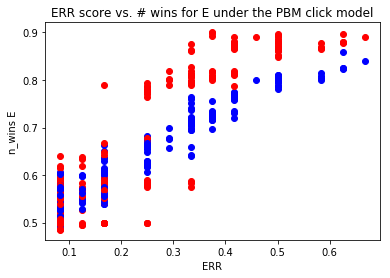

In [10]:
for i, interleaving in enumerate(interleavings):
    plt.plot(interleaving.pair.delta_ERR, interleaving.wins_team_draft_pbm, 'ro')
    plt.plot(interleaving.pair.delta_ERR, interleaving.wins_probabilistic_pbm, 'bo')
    
plt.xlabel("ERR")
plt.ylabel("n_wins E")
plt.title("ERR score vs. # wins for E under the PBM click model")
plt.show()

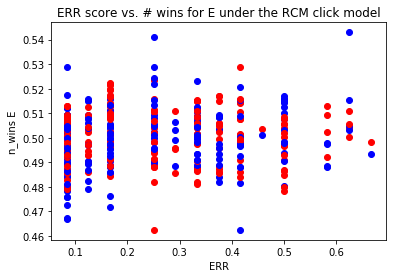

In [11]:
for i, interleaving in enumerate(interleavings):
    plt.plot(interleaving.pair.delta_ERR, interleaving.wins_team_draft_rcm, 'ro')
    plt.plot(interleaving.pair.delta_ERR, interleaving.wins_probabilistic_rcm, 'bo')
    
plt.xlabel("ERR")
plt.ylabel("n_wins E")
plt.title("ERR score vs. # wins for E under the RCM click model")
plt.show()

### Step 5: Compute sample size
We use each one of the afore-computed proportions to compute the sample size needed to detect such a proportion in a statistically significant manner. We allow a chance of falsely rejecting the null hypothesis (i.e. concluding that E is better than P, when it is not) of 5% and a chance of falsely not rejecting the null hypothesis (i.e. not concluding that E is better than P, when it is) of 10%. We use the values above for a power analysis of the proportion test, for the 1-sided case.


In [12]:
def determine_sample_size(alpha, beta, p1):
    """
    Calculate required number of expressions with given alpha and beta.
    """
    
    
    p0 = 0.5
    z_alpha = st.norm.ppf(1-alpha) 
    z_beta = st.norm.ppf(1-beta)
    min_N = ((z_alpha * (p0*(1-p0))**.5 + z_beta * (p1*(1-p1))) / (np.abs(p1-p0)))**2
    
    # continutity correction 
    N = min_N + 1 / (np.abs(p1-p0))
    
    return N

def sample_size_interval(all_sample_sizes):
    
    """
    Determine minimum, maximum and median of a given list of sample sizes.
    """
    
    if not all_sample_sizes:
        minimum, median, maximum = 0, 0, 0
        
    else: 
        np.array(all_sample_sizes)
        median = np.median(all_sample_sizes)
        maximum = np.max(all_sample_sizes)
        minimum = np.min(all_sample_sizes)
    
    return minimum, median, maximum

# Define variables
alpha = 0.05
beta = 0.1
all_n_team_draft_pbm = []
all_n_probabilistic_pbm = []
all_n_team_draft_rcm = []
all_n_probabilistic_rcm = []

# iterate over interleavings
for i in interleavings:
    
    # calculate sample size for all possibilities and store in list
    N_t_pbm = determine_sample_size(alpha, beta, i.wins_team_draft_pbm)
    N_p_pbm = determine_sample_size(alpha, beta, i.wins_probabilistic_pbm)
    N_t_rcm = determine_sample_size(alpha, beta, i.wins_team_draft_rcm)
    N_p_rcm = determine_sample_size(alpha, beta, i.wins_probabilistic_rcm)
    all_n_team_draft_pbm.append((i.pair.delta_ERR, N_t_pbm))
    all_n_probabilistic_pbm.append((i.pair.delta_ERR, N_p_pbm))
    all_n_team_draft_rcm.append((i.pair.delta_ERR, N_t_rcm))
    all_n_probabilistic_rcm.append((i.pair.delta_ERR, N_p_rcm))
    
# seperate results based on delta_ERR for all possibilities
group1 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.05 and result[0]<0.1)]
group2 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.1 and result[0]<0.2)]
group3 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.2 and result[0]<0.3)]
group4 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.3 and result[0]<0.4)]
group5 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.4 and result[0]<0.5)]
group6 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.5 and result[0]<0.6)]
group7 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.6 and result[0]<0.7)]
group8 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.7 and result[0]<0.8)]
group9 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.8 and result[0]<0.9)]
group10 = [result[1] for result in all_n_team_draft_pbm if (result[0]>=0.9 and result[0]<=0.95)]

results_team_draft_pbm = {'[0.05-0.1)': group1, '[0.1-0.2)': group2, '[0.2-0.3)': group3, '[0.3-0.4)': group4, \
                      '[0.4-0.5)': group5, '[0.5-0.6)': group6, '[0.6-0.7)': group7, '[0.7-0.8)': group8, \
                      '[0.8-0.9)': group9, '[0.9-0.95]': group10}

group1_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.05 and result[0]<0.1)]
group2_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.1 and result[0]<0.2)]
group3_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.2 and result[0]<0.3)]
group4_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.3 and result[0]<0.4)]
group5_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.4 and result[0]<0.5)]
group6_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.5 and result[0]<0.6)]
group7_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.6 and result[0]<0.7)]
group8_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.7 and result[0]<0.8)]
group9_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.8 and result[0]<0.9)]
group10_p = [result[1] for result in all_n_probabilistic_pbm if (result[0]>=0.9 and result[0]<=0.95)]

results_probabilistic_pbm = {'[0.05-0.1)': group1_p, '[0.1-0.2)': group2_p, '[0.2-0.3)': group3_p, '[0.3-0.4)': group4_p, \
                         '[0.4-0.5)': group5_p, '[0.5-0.6)': group6_p, '[0.6-0.7)': group7_p, '[0.7-0.8)': group8_p, \
                         '[0.8-0.9)': group9_p, '[0.9-0.95]': group10_p}

group1 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.05 and result[0]<0.1)]
group2 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.1 and result[0]<0.2)]
group3 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.2 and result[0]<0.3)]
group4 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.3 and result[0]<0.4)]
group5 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.4 and result[0]<0.5)]
group6 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.5 and result[0]<0.6)]
group7 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.6 and result[0]<0.7)]
group8 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.7 and result[0]<0.8)]
group9 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.8 and result[0]<0.9)]
group10 = [result[1] for result in all_n_team_draft_rcm if (result[0]>=0.9 and result[0]<=0.95)]

results_team_draft_rcm = {'[0.05-0.1)': group1, '[0.1-0.2)': group2, '[0.2-0.3)': group3, '[0.3-0.4)': group4, \
                      '[0.4-0.5)': group5, '[0.5-0.6)': group6, '[0.6-0.7)': group7, '[0.7-0.8)': group8, \
                      '[0.8-0.9)': group9, '[0.9-0.95]': group10}

group1_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.05 and result[0]<0.1)]
group2_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.1 and result[0]<0.2)]
group3_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.2 and result[0]<0.3)]
group4_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.3 and result[0]<0.4)]
group5_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.4 and result[0]<0.5)]
group6_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.5 and result[0]<0.6)]
group7_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.6 and result[0]<0.7)]
group8_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.7 and result[0]<0.8)]
group9_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.8 and result[0]<0.9)]
group10_p = [result[1] for result in all_n_probabilistic_rcm if (result[0]>=0.9 and result[0]<=0.95)]

results_probabilistic_rcm = {'[0.05-0.1)': group1_p, '[0.1-0.2)': group2_p, '[0.2-0.3)': group3_p, '[0.3-0.4)': group4_p, \
                         '[0.4-0.5)': group5_p, '[0.5-0.6)': group6_p, '[0.6-0.7)': group7_p, '[0.7-0.8)': group8_p, \
                         '[0.8-0.9)': group9_p, '[0.9-0.95]': group10_p}

mins_t_rcm, mins_p_rcm, meds_t_rcm, meds_p_rcm, maxs_t_rcm, maxs_p_rcm = [], [], [], [], [], []
minimums_t, minimums_p, medians_t, medians_p, maximums_t, maximums_p = [], [], [], [], [], []

# calculate statistics
for group in results_team_draft_pbm.values():
    minimum_t, median_t, maximum_t = sample_size_interval(group)
    minimums_t.append(minimum_t)
    medians_t.append(median_t)
    maximums_t.append(maximum_t)
    
for group in results_probabilistic_pbm.values():
    minimum_p, median_p, maximum_p = sample_size_interval(group)
    minimums_p.append(minimum_p)
    medians_p.append(median_p)
    maximums_p.append(maximum_p)

for group in results_team_draft_rcm.values():
    min_t_rcm, med_t_rcm, max_t_rcm = sample_size_interval(group)
    mins_t_rcm.append(min_t_rcm)
    meds_t_rcm.append(med_t_rcm)
    maxs_t_rcm.append(max_t_rcm)
    
for group in results_probabilistic_rcm.values():
    min_p_rcm, med_p_rcm, max_p_rcm = sample_size_interval(group)
    mins_p_rcm.append(min_p_rcm)
    meds_p_rcm.append(med_p_rcm)
    maxs_p_rcm.append(max_p_rcm)

headers = ['Delta_ERR', 'Minimum', 'Median', 'Maximum']
deltaERR = ['[0.05-0.1)', '[0.1-0.2)', '[0.2-0.3)', '[0.3-0.4)', '[0.4-0.5)', '[0.5-0.6)', '[0.6-0.7)', \
            '[0.7-0.8)', '[0.8-0.9)', '[0.9-0.95]']

# table teamdraft PCM
print("Results team-draft interleaving for the PBM click model:")    
table_t = tt.Texttable()
table_t.header(headers)
for row in zip(deltaERR, minimums_t, medians_t, maximums_t):
    table_t.add_row(row)
tab_t = table_t.draw()
print(tab_t)
print('\n')

#  table prob RCM
print("Results probabilistic interleaving for the PBM click model:")    
table_p = tt.Texttable()
table_p.header(headers)

for row in zip(deltaERR, minimums_p, medians_p, maximums_p):
    table_p.add_row(row)
tab_p = table_p.draw()
print(tab_p)
print('\n')

# table team-draft PCM
print("Results team-draft interleaving for the RCM click model:")    
table_p_rcm = tt.Texttable()
table_p_rcm.header(headers)

for row in zip(deltaERR, mins_t_rcm, meds_t_rcm, maxs_t_rcm):
    table_p_rcm.add_row(row)
tab_p_rcm = table_p_rcm.draw()
print(tab_p_rcm)
print('\n')

# table for prob RCM
print("Results probabilistic interleaving for the RCM click model:")    
table_p_rcm = tt.Texttable()
table_p_rcm.header(headers)

for row in zip(deltaERR, mins_p_rcm, meds_p_rcm, maxs_p_rcm):
    table_p_rcm.add_row(row)
tab_p_rcm = table_p_rcm.draw()
print(tab_p_rcm)
print('\n')



Results team-draft interleaving for the PBM click model:
+------------+---------+---------+-----------+
| Delta_ERR  | Minimum | Median  |  Maximum  |
+============+=========+=========+===========+
| [0.05-0.1) | 69.888  | 489.964 | 1.177e+31 |
+------------+---------+---------+-----------+
| [0.1-0.2)  | 16.246  | 220.382 | 1.177e+31 |
+------------+---------+---------+-----------+
| [0.2-0.3)  | 13.162  | 44.459  | 1.177e+31 |
+------------+---------+---------+-----------+
| [0.3-0.4)  | 7.973   | 14.191  | 242.596   |
+------------+---------+---------+-----------+
| [0.4-0.5)  | 8.422   | 9.596   | 18.665    |
+------------+---------+---------+-----------+
| [0.5-0.6)  | 8.112   | 9.625   | 10.859    |
+------------+---------+---------+-----------+
| [0.6-0.7)  | 8.182   | 8.957   | 9.064     |
+------------+---------+---------+-----------+
| [0.7-0.8)  | 0       | 0       | 0         |
+------------+---------+---------+-----------+
| [0.8-0.9)  | 0       | 0       | 0         |
+--

### Step 6: Analysis


Firstly, for the Random Click Model, there is no relationship between the ERR score of a ranking, its proportion of wins, and subsequently the required sample size. This is as expected: if clicks are allocated randomly, without regard for the quality of a ranking, we expect that both rankers that are part of the interleaving win an equal number of times. Indeed, the mean proportion of wins for E is 0.5. In addition, the required sample size goes to infinity when there is no difference between the win proportions of E and P (as the denominator of the formula to calculate sample size becomes zero).

For the Position-Based Model, we do find a relationship between sample size and ERR score. For both interleaving algorithms, the required sample size decreases when ranking E outperforms ranking P a larger fraction of the time. This makes sense, since we assume that a more extreme outcome in the offline experiment will need fewer impressions to get a significant result in the online experiment. Moreover, we see a large difference in the range of the required sample sizes (i.e. maximum-minimum). As the win proportion of E approaches 0.5, i.e. E is of nearly-equal quality to P, the number of required impressions becomes very large, and the maximum value goes to infinity. This makes sense intuitively: if the difference between E and P is very small, we would need to observe them very often to convince ourselves that the marginally better results of E are not just due to randomness. If the difference is very large, we only need a few examples to believe that the difference is due to an inherent better quality of E.

Secondly, we find that the team-draft interleaving algorithm needs fewer samples in the online experiment to get significant results. As such, it could be preferable in a real experiment. However, the variance is higher than in probabilistic interleaving, as the maximum values are more rapidly decreasing for this algorithm. It can be concluded that choosing the top result (as is done for team-draft interleaving) is not always beneficial. On the contrary, uncertainty in the sample size can actually be decreased by allowing some probabilistic distribution over choosing a document of E and P. 

To summarize, the ERR intervals provide a broad view of the necessary impressions for our experiment. The division clearly shows that the sample size is highly correlated with the ERR gap. Both interleaving algorithms have a decreasing number of required samples, as expected, but differ in range values. In our research we have found a method to estimate the sample size, and as such the expected duration, of an online experiment given the results of the offline experiment. The results of an offline experiment usually can be collected very quickly, while it is expensive and time-consuming to perform an online experiment. Using the funnel approach we outline here, researchers can estimate the expected costs of an online experiment better. 

Naturally, our research has several limitations. In the offline experiment, we find that the optimal ERR score (for a relevance ranking of [1, 1, 1] is 0.66. As such, we cannot estimate sample sizes for the last few buckets of our table. Another score metric (such as DCG, MAP) could lead to different results. Besides, we have made several simplifying assumptions that mean that our expected sample sizes likely under-estimate the true sample size required. For instance, we have assumed that queries cannot vary in the online and offline experiment. Relaxation of this premise could lead to a more realistic model of user behaviour. Moreover, we have simulated click results based on a dataset in order to estimate parameters for the click models, and subsequently simulated clicks with these models. However, the PBM is likely a simplification of the true click behavior of users, and more advanced and realistic models (such as the cascade model) exist. Also, the binary relevance labels we have assumed are most likely much too simplistic, and a relevance grade with more scales is likely to be more representative of reality. The same goes for the length of the interleaved results: in a realistic setting, a search engine would always deliver more than three results, and we expect that the results at rank 4 and below matter in the quality of a search algorithm. Extending the length of the interleaving to a higher rank would therefore lead to more realistic results. Finally, the choice of interleaving can be reconsidered. The main problem with interleaving is that it does not distinguish between users. Other methods with a similar purpose are of course also applicable and might be more suitable.